In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.options.display
train = pd.read_csv('/content/drive/MyDrive/SMFG/train.csv', index_col=0) # 学習用データ
test = pd.read_csv('/content/drive/MyDrive/SMFG/test.csv', index_col=0) # 学習用データ   # 評価用データ
sample_submit = pd.read_csv('/content/drive/MyDrive/SMFG/sample_submission.csv', index_col=0, header=None) # 応募用サンプルファイル

# Preprocessing

In [ ]:
test.head()

,created_at,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
19984,2015-09-08,15,OnCurb,NaN,NaN,Damage,NYC Parks Staff,NaN,Callery pear,Pyrus calleryana,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,3,3062000,Brooklyn,Brooklyn,315,22,45,48
19985,2015-10-15,5,OnCurb,1or2,NaN,NoDamage,Volunteer,NaN,cherry,Prunus,BX62,Woodlawn-Wakefield,2,2045101,Bronx,Bronx,212,34,81,11
19986,2016-08-03,4,OnCurb,NaN,Unsure,NoDamage,Volunteer,NaN,littleleaf linden,Tilia cordata,QN60,Kew Gardens,4,4013800,Queens,Kew Gardens,409,14,27,29
19987,2015-08-06,7,OnCurb,NaN,NaN,NoDamage,TreesCount Staff,NaN,dawn redwood,Metasequoia glyptostroboides,BK09,Brooklyn Heights-Cobble Hill,3,3000301,Brooklyn,Brooklyn,302,26,52,33
19988,2015-10-21,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff,Stones,purple-leaf plum,Prunus cerasifera,BK75,Bedford,3,3025100,Brooklyn,Brooklyn,303,25,56,36


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 19  st_assem    19984 non-null  int64 
 20  cncldi

# Learning

In [ ]:
NFOLD = 5
SEED = 42
NROUND = 100000
ETA = 0.1
ESR = 20
LOGLEVEL = 20

In [ ]:
train['Branch'] = train['problems'].str.contains('Branch')
test['Branch'] = test['problems'].str.contains('Branch')
train['MetalGrates'] = train['problems'].str.contains('MetalGrates')
test['MetalGrates'] = test['problems'].str.contains('MetalGrates')
train['RootOther'] = train['problems'].str.contains('RootOther')
test['RootOther'] = test['problems'].str.contains('RootOther')
train['Stones'] = train['problems'].str.contains('Stones')
test['Stones'] = test['problems'].str.contains('Stones')
train['Trunk'] = train['problems'].str.contains('Trunk')
test['Trunk'] = test['problems'].str.contains('Trunk')
train['WiresRope'] = train['problems'].str.contains('WiresRope')
test['WiresRope'] = test['problems'].str.contains('WiresRope')

In [ ]:
target = "health"
features = [col for col in train.columns if col not in target]
categories = ["created_at", "curb_loc", "steward", "guards", "sidewalk", "user_type", "problems", "spc_common", "spc_latin", "nta", "nta_name", "boroname", "zip_city", "Branch", "MetalGrates", "RootOther", "Stones", "Trunk", "WiresRope"]

In [ ]:
train['created_at'] = train['created_at'].map(lambda x: x[:7])
test['created_at'] = test['created_at'].map(lambda x: x[:7])

In [ ]:
def stratified(X_train, y_train, SEED=SEED, NFOLD=NFOLD):
  trn_idx_list = []
  val_idx_list = []
  folds = StratifiedKFold(
      n_splits=NFOLD,
      shuffle=True,
      random_state=SEED
  )
  return list(folds.split(X_train.values, y_train.values))

In [ ]:
for cat in categories:
  ser = pd.concat([train[cat], test[cat]]).astype('category')
  train[cat] = ser.iloc[:len(train)]
  test[cat] = ser.iloc[len(train):]

In [ ]:
X_train = train[features]
y_train = train[target]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 0 to 19983
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   created_at   19984 non-null  category
 1   tree_dbh     19984 non-null  int64   
 2   curb_loc     19984 non-null  category
 3   steward      5101 non-null   category
 4   guards       5041 non-null   category
 5   sidewalk     19984 non-null  category
 6   user_type    19984 non-null  category
 7   problems     7741 non-null   category
 8   spc_common   19984 non-null  category
 9   spc_latin    19984 non-null  category
 10  nta          19984 non-null  category
 11  nta_name     19984 non-null  category
 12  borocode     19984 non-null  int64   
 13  boro_ct      19984 non-null  int64   
 14  boroname     19984 non-null  category
 15  zip_city     19984 non-null  category
 16  cb_num       19984 non-null  int64   
 17  st_senate    19984 non-null  int64   
 18  st_assem     19984 non-nul

In [ ]:
cv = stratified(X_train, y_train)

In [ ]:
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'learning_rate': ETA,
    'max_depth': -1,
    'num_leaves': 31,
    'bagging_fraction': 1.0,
    'feature_fraction': 1.0,
    'bagging_freq': 0,
    'random_state': SEED,
    'verbosity': -1,
}

In [ ]:
models = []
val_scores = []
importances = pd.DataFrame()
oof_preds = np.zeros((len(train), 3))
scores_logloss = []

for i, (trn_idx, val_idx) in enumerate(cv):
  print(f'\nFold: {i} start prediction.')

  trn_x, trn_y = X_train.iloc[trn_idx], y_train[trn_idx]
  val_x, val_y = X_train.iloc[val_idx], y_train[val_idx]

  dtrain = lgb.Dataset(trn_x, label=trn_y, weight=compute_sample_weight(class_weight='balanced', y=trn_y).astype('float32'))
  dvalid = lgb.Dataset(val_x, label=val_y, weight=np.ones(len(val_x)).astype('float32'))

  evals_result = {}
  model = lgb.train(
      params,
      train_set=dtrain,
      num_boost_round=NROUND,
      valid_sets=[dtrain, dvalid],
      valid_names=['training', 'valid'],
      callbacks=[
          lgb.early_stopping(stopping_rounds=ESR, verbose=True),
          lgb.log_evaluation(LOGLEVEL)
      ]
  )

  models.append(model)

  val_preds = model.predict(val_x, num_iteration=model.best_iteration)
  oof_preds[val_idx] = val_preds

  val_score = roc_auc_score(val_y, val_preds, multi_class='ovo')
  # f1_score = f1_score(val_y, val_preds)
  print(f'Fold{i} roc_auc_score: {val_score}')
  val_scores.append(val_score)

  logloss = log_loss(val_y, val_preds)
  scores_logloss.append(logloss)

  imp_df = pd.DataFrame({
      'feature': model.feature_name(),
      'gain': model.feature_importance(importance_type='gain'),
      'fold': i
  })
  importances = pd.concat([importances, imp_df], axis=0)

print('========== end prediction ==========')
auc_score_mean = np.mean(val_scores)
logloss_mean = np.mean(scores_logloss)
auc_score_all = roc_auc_score(y_train, oof_preds, multi_class='ovo')
print(f'auc_score_all: {auc_score_all}, auc_score_mean: {auc_score_mean}, logloss_mean: {logloss_mean}')


Fold: 0 start prediction.
Training until validation scores don't improve for 20 rounds
[20]	training's multi_logloss: 0.765668	valid's multi_logloss: 0.968413
[40]	training's multi_logloss: 0.623224	valid's multi_logloss: 0.909553
[60]	training's multi_logloss: 0.536142	valid's multi_logloss: 0.87142
[80]	training's multi_logloss: 0.478387	valid's multi_logloss: 0.848103
[100]	training's multi_logloss: 0.435095	valid's multi_logloss: 0.832606
[120]	training's multi_logloss: 0.399777	valid's multi_logloss: 0.820711
[140]	training's multi_logloss: 0.368669	valid's multi_logloss: 0.811239
[160]	training's multi_logloss: 0.341779	valid's multi_logloss: 0.803426
[180]	training's multi_logloss: 0.317398	valid's multi_logloss: 0.79804
[200]	training's multi_logloss: 0.296217	valid's multi_logloss: 0.792835
[220]	training's multi_logloss: 0.277319	valid's multi_logloss: 0.78958
[240]	training's multi_logloss: 0.260959	valid's multi_logloss: 0.787383
[260]	training's multi_logloss: 0.244012	va

In [ ]:
np.unique(np.argmax(oof_preds, axis=1), return_counts=True)

(array([0, 1, 2]), array([ 3995, 15437,   552]))

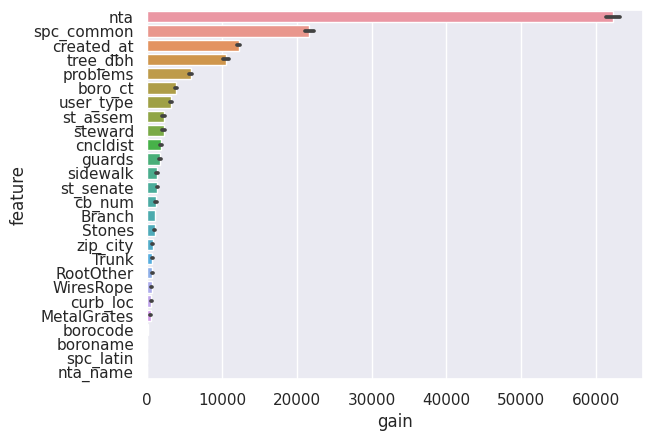

In [ ]:
sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));

# Predicting

In [ ]:
test_preds = np.zeros((len(test), 3))
for model in models:
  test_pred = model.predict(test) / NFOLD
  test_preds += test_pred
np.unique(np.argmax(test_preds, axis=1), return_counts=True)

(array([0, 1, 2]), array([ 3296, 16013,   393]))

In [ ]:
sample_submit[1] = np.argmax(test_preds, axis=1)
sample_submit.to_csv('/content/drive/MyDrive/SMFG/submit_lightgbm_problems.csv', header=None)